# Contents
1. Introduction
2. Study of Temperature Change over the years. Can we identify a pattern there?
3. Trend Analysis on Temperature Data. How to Quantify the trend of temperature Data over the years?
4. Explore Seasonality and Outliers in Temperature Data
5. Is there notable deviations in the temperature data over the years?
6. Is there any correlation between the maximum average temperature and Different Environment Indicators?
7. Analyse the trends of different Environmental Indicators and study their behaviour. Is there some interesting behaviour?
   1. Analysing Indicators with Negative Trends.
      1. Nitrogen Oxide Emission
      2. Green House Gas Emission
   2. Analyse indicators with Positive Trends
      1. Household Wastes
      2. Recycling Rate
      3. Settlement Area

8. Predict Average Temperature from Time series Data
9. Conclusion


# Introduction
The project explores various environmental indicators from the German state of North Rhine-Westphalia.

We have Environmental indicator data for the region from 1981 to 2021. We also have the average yearly temperature from the same region which is considered here as an indicator of Climate change.
In this project, we aim to explore the relationship between different environmental indicators and average yearly temperature and with each other.
By examining these factors together, we can gain a comprehensive understanding of how environmental changes and temperature fluctuations interact and influence each other.

The project also tries to assess the trends and patterns in different environmental indicators over time by analyzing time series data.
By analyzing the historical data, we can identify whether environmental indicators have been improving, deteriorating, or remaining stable.
The Average  temperature data is available from 1880 to 2022, which would enable us to  some temperature forcasting with the data.

In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from data.utils import  print_colored
import warnings

## Study the change of Temperature over the years. Can we identify a pattern there?


Text(0.5, 1.0, 'Temperature')

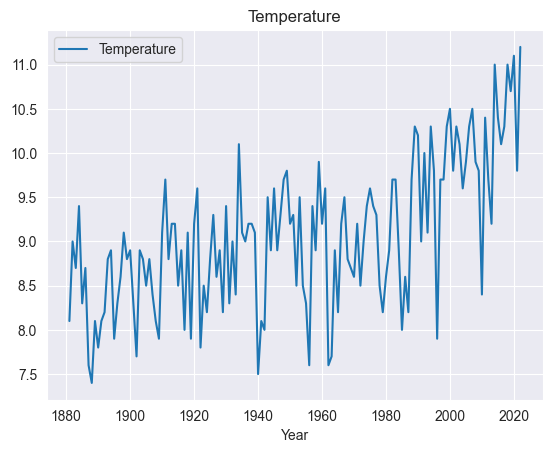

In [288]:
temperature_df =  pd.read_sql_table('temperature', 'sqlite:///../data/dataset.sqlite',coerce_float = True)
temperature_df.set_index('Year', inplace=True)
temperature_df.plot()
plt.title('Temperature')

### We can see a steady raise of average temperature over the years. 
### How to Quantify the trend of temperature Data over the years?
Let's do a trend analysis on Temperature data by fitting a linear regression line to formally Quantify the trend of the data set

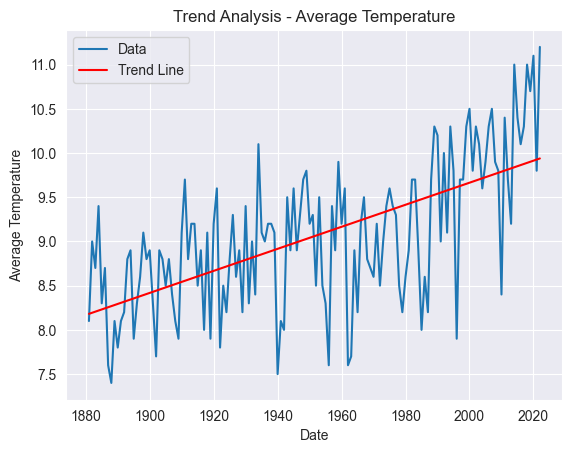

In [289]:
temperature_real_df =  pd.read_sql_table('temperature', 'sqlite:///../data/dataset.sqlite',coerce_float = True)
temperature_df = temperature_real_df.reset_index()
temperature_df['Year'] = pd.to_datetime(temperature_real_df['Year'], format='%Y')
temperature_df.set_index('Year', inplace=True)


x = np.arange(len(temperature_df)).reshape(-1, 1)
y = temperature_df['Temperature'].values.reshape(-1, 1)

regression_model = LinearRegression()
regression_model.fit(x, y)
slope = regression_model.coef_[0]
intercept = regression_model.intercept_

# Plot the original data
plt.plot(temperature_df.index, y, label='Data')

# Plot the linear regression line
regression_line = slope * x + intercept
plt.plot(temperature_df.index, regression_line, color='red', label='Trend Line')

# Add labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.title('Trend Analysis - Average Temperature')
plt.legend()

# Display the plot
plt.show()


In [290]:
print('slope of the line', slope)

slope of the line [0.01246356]


There is a clear positive trend in the average temperature through the years
We get a slope of 0.01246356 which denotes the rate of change of the average temperature per year.
So the average temperature is increasing by approximately 1.25% each year

## Explore Seasonality
Seasonality Explores seasonal patterns in the average temperature data.
We can check if there is some recurring pattern that could be seen in intervals of years
Are there recurring patterns that occur within each year? Let's analyse if there are specific months or seasons with consistently higher or lower temperatures.
One method to do seasonality analysis is Seasonal Decomposition of Time Series by Loess (STL).
We can do the analysis using the statsmodels library.

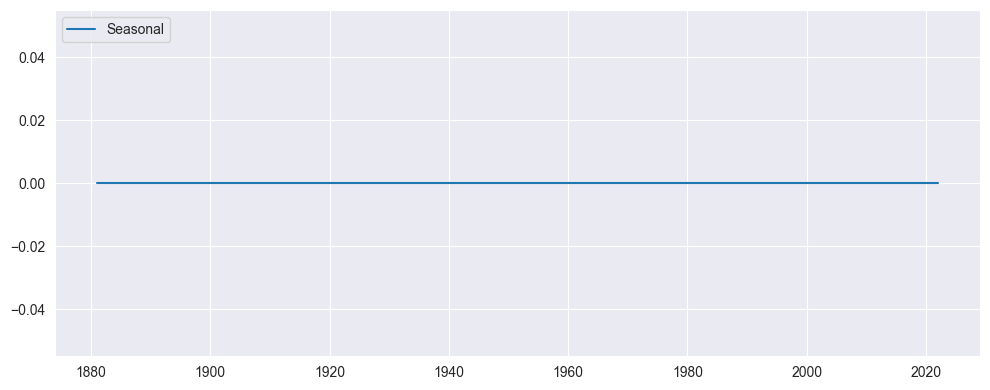

In [291]:
decomposition = sm.tsa.seasonal_decompose(temperature_df['Temperature'], model='additive')

# Extract the seasonal, trend, and residual components
seasonal = decomposition.seasonal
trend = decomposition.trend
residual = decomposition.resid

# Plot the components
plt.figure(figsize=(10, 4))

plt.plot(temperature_df.index, seasonal, label='Seasonal')
plt.legend(loc='upper left')


plt.tight_layout()
plt.show()

### The model could not see any seasonal trend in our data - which is expected since our time series is per year
If we analyse data per month, we can perhaps deduct some seasonality trend

### Is there notable deviations in the temperature data over the years?
Now let's study the yearly temperature differences to study substantial differences compared to previous years
We define a thresholds = 1,1.5,1.75 and see if on which years the average temperature differed significantly from the threshold

In [292]:

diff  = temperature_df['Temperature'].diff()

def get_years_outside_threshold(threshold):
    positive_diff_years = diff[diff > threshold]
    negative_diff_years = diff[diff < -threshold]
    print_colored(f"{len(positive_diff_years)} Years has deviated from previous years by  {threshold} degree", 'red')
    print('Years are' ,positive_diff_years.index.year.values)
    print_colored(f"{len(negative_diff_years)} Years has deviated from previous years by  -{threshold} degree", 'red')
    print('Years are' ,negative_diff_years.index.year.values)

get_years_outside_threshold(1.75)
get_years_outside_threshold(1.5)
get_years_outside_threshold(1)

4 Years has deviated from previous years by  1.75 degree
Years are [1957 1997 2011 2014]
3 Years has deviated from previous years by  -1.75 degree
Years are [1922 1962 1996]
5 Years has deviated from previous years by  1.5 degree
Years are [1934 1957 1997 2011 2014]
4 Years has deviated from previous years by  -1.5 degree
Years are [1922 1940 1962 1996]
15 Years has deviated from previous years by  1 degree
Years are [1903 1910 1918 1920 1930 1934 1943 1957 1964 1988 1994 1997 2011 2014
 2022]
11 Years has deviated from previous years by  -1 degree
Years are [1885 1887 1919 1922 1931 1940 1962 1991 1996 2010 2021]


## Identify Outliers in data
Let's collect a some statistical information from the temperature data to better understand it
We are trying to identify years with unusually high or low average temperature compared to typical range.
We can use z-scores test and define a threshold to identify them and also draw a box plot to figure out big outliers

In [293]:

temperature = temperature_df['Temperature']
year = temperature_df.index
print_colored('TEMPERATURE DATA DESCRIPTION','green')
print_colored(temperature.describe(), 'blue')
z_scores = (temperature - temperature.mean()) / temperature.std()
# Set a threshold to identify outliers (e.g., z-score greater than 2 or less than -2)
threshold = 2.0

# Filter years with z-scores exceeding the threshold
outlier_years = year[np.abs(z_scores) > threshold]
print_colored('OUTLIER  INFO','green')
print_colored("The outlier years falling out of at least 2 standard deviations are :", 'blue')
print_colored(outlier_years.year.values, 'blue')

TEMPERATURE DATA DESCRIPTION
count    142.000000
mean       9.059859
std        0.831137
min        7.400000
25%        8.500000
50%        9.000000
75%        9.675000
max       11.200000
Name: Temperature, dtype: float64
OUTLIER  INFO
The outlier years falling out of at least 2 standard deviations are :
[2014 2018 2020 2022]


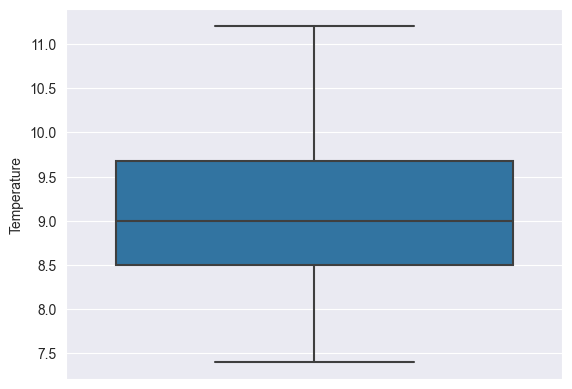

In [294]:
## Box Plot to Identify outliers
sns.boxplot(y=temperature)
plt.show()

Looking at the box plot, it seems like our data does not contain huge outliers

# Environmental Indicators

First data frame is loaded from the local SQLlite DataBase
We check data info to identify missing values and general nature of data

In [295]:
df = pd.read_sql_table('env_indicators', 'sqlite:///../data/dataset.sqlite',coerce_float = True)
df_t= df.T
df_t = df_t.set_axis(df_t.iloc[0], axis=1).drop(df_t.index[0])
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 1983 to 2021
Data columns (total 30 columns):
 #   Column                                                                                                  Non-Null Count  Dtype 
---  ------                                                                                                  --------------  ----- 
 0   no2_concentration_urban--Stickstoffdioxidkonzentration                                                  32 non-null     object
 1   Land consumption--Settlement and traffic area                                                           26 non-null     object
 2   nitrogen_oxide_emission--Industry                                                                       7 non-null      object
 3   nitrogen_oxide_emission--Small combustion plants                                                        7 non-null      object
 4   nitrogen_oxide_emission--Traffic                                                                    

Seems like there a quite number of empty values in the data.
We may need to employ suitable interpolation techniques to circumvent that.
Here i am using a simple back fill followed by forward bill to for the missing values to be copied from their neighboring value

In [296]:
# Interpolate Data to fill from historic values
df = df.fillna(method='bfill',axis=1)
df = df.fillna(method='ffill',axis=1)
df_t= df.T
df_t = df_t.set_axis(df_t.iloc[0], axis=1).drop(df_t.index[0])
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 1983 to 2021
Data columns (total 30 columns):
 #   Column                                                                                                  Non-Null Count  Dtype 
---  ------                                                                                                  --------------  ----- 
 0   no2_concentration_urban--Stickstoffdioxidkonzentration                                                  39 non-null     object
 1   Land consumption--Settlement and traffic area                                                           39 non-null     object
 2   nitrogen_oxide_emission--Industry                                                                       39 non-null     object
 3   nitrogen_oxide_emission--Small combustion plants                                                        39 non-null     object
 4   nitrogen_oxide_emission--Traffic                                                                    

## Now let's try to find correlation between the maximum average temperature and different environmental indicators

In [298]:
correlation_matrix = df_t.corr()
correlation_with_temperature = correlation_matrix['temperature--Temperature']

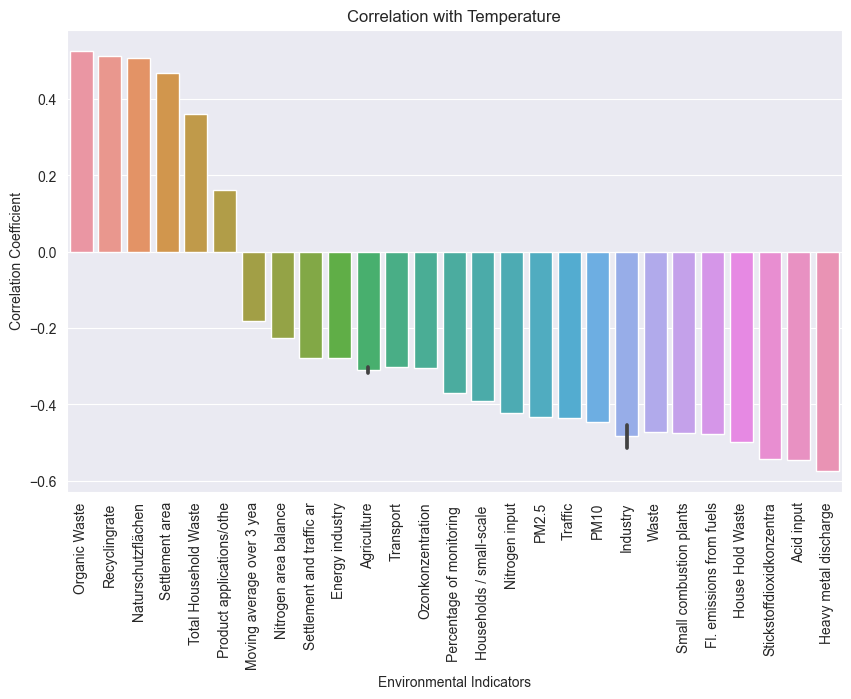

In [299]:
sorted_correlations = correlation_with_temperature.sort_values(ascending=False)
plt.figure(figsize=(10, 6))  # Set the figure size
formatted_cols = [element.split("--")[-1][0:25] for element in sorted_correlations.index.values]
# formatted_cols = sorted_correlations.index.values

sns.barplot(x=formatted_cols[1:], y=sorted_correlations.values[1:])
plt.title('Correlation with Temperature')  # Set the title of the plot
plt.xlabel('Environmental Indicators')  # Set the x-axis label
plt.ylabel('Correlation Coefficient')  # Set the y-axis label
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


This result is kind of surprising, as we can see a positive correlation between good environmental indicators and increase in temperature
Let's try to see the most and least correlated features to temperature

In [300]:
temp_correlation_positive_cols = sorted_correlations.index.values[1:6]
temp_correlation_negative_cols = sorted_correlations.index.values[-5:]
print(temp_correlation_positive_cols)
print(temp_correlation_negative_cols)

['household_waste--Organic Waste' 'Recycling rate--Recyclingrate'
 'Nature Conservation--Naturschutzflächen'
 'Settlement area--Settlement area'
 'household_waste--Total Household Waste']
['household_waste--House Hold Waste' 'nitrogen_oxide_emission--Industry'
 'no2_concentration_urban--Stickstoffdioxidkonzentration'
 'acid_input--Acid input' 'heavy_metal_rural--Heavy metal discharge']


## Positively Correlated Indicators

<Figure size 1000x1000 with 0 Axes>

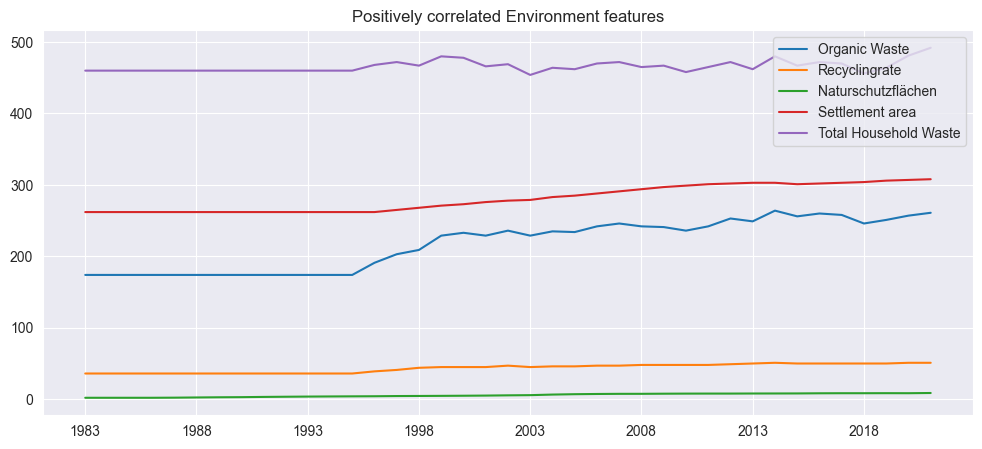

In [301]:
# Plotting Positively correlated indicators
plt.figure(figsize=(10, 10))
legends = formatted_cols[1:6]
df_t[temp_correlation_positive_cols].astype(float).plot(figsize=(12, 5))
plt.gca().legend(legends)
plt.title('Positively correlated Environment features')
plt.show()

## All the features except the Total Household waste and settlement area should have a positive effect on the environment
By studying the features it is fair to make the following assumptions
   1. Environmental protection efforts and awareness has helped in Increasing Recycling Rate
   2. Proper waste segregation has improved over the years leading to increase in Organic waster and decrease in other type of wastes
   3. Nature conservation has also seen an improvement over the years
   4. Total household waste has increased but organic wastes contributed to that increase as there is a reduction in other typf of household wastes
   5. There is an increase in settlement areas which could be a factor affecting climate change
   6. The above concluded correlation between the positive indicators and increase in temperature could be just because of the increasing trend in them over the years not because of any underlying positive correlated relationship

## Negatively Correlated Indicators

<Figure size 1000x1000 with 0 Axes>

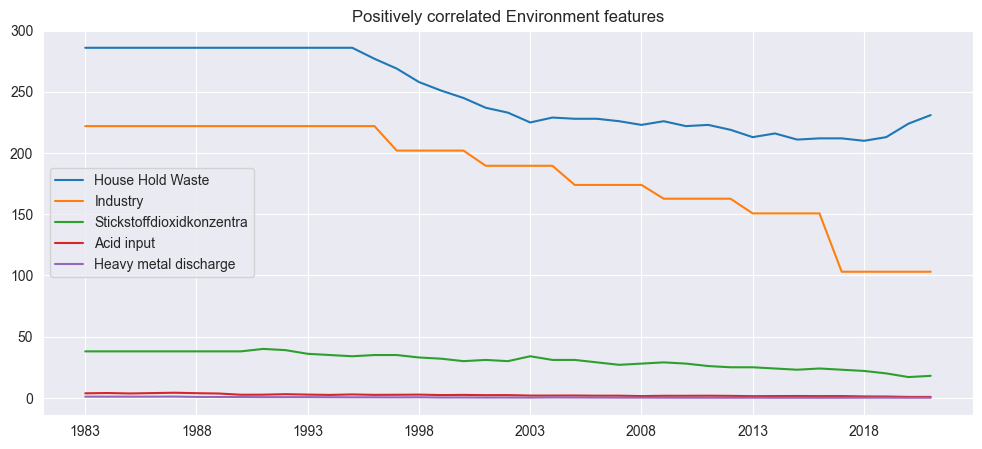

In [302]:
plt.figure(figsize=(10, 10))
legends = formatted_cols[-5:]
df_t[temp_correlation_negative_cols].astype(float).plot(figsize=(12, 5))
plt.gca().legend(legends)
plt.title('Positively correlated Environment features')
plt.show()

Similar to the positive correlation, the negative correlated feature also poses a surprising result
The features like Household Waste, nitrogen dioxide concentrate, Acid input, Heavy metal discharge and no2 emission adversely affects the climate change.
But it is shown to be negatively correlated.
We can  conclude that only the downward trend of the indicator over the years is the only correlation between climate data and these indicators

In [303]:
print(sorted_correlations.index.values)

['temperature--Temperature' 'household_waste--Organic Waste'
 'Recycling rate--Recyclingrate' 'Nature Conservation--Naturschutzflächen'
 'Settlement area--Settlement area'
 'household_waste--Total Household Waste'
 'greenhouse_gas--Product applications/other'
 'Nitrogen area balance--Moving average over 3 years'
 'Nitrogen area balance--Nitrogen area balance'
 'Land consumption--Settlement and traffic area '
 'greenhouse_gas--Energy industry' 'greenhouse_gas--Agriculture'
 'greenhouse_gas--Transport' 'o3-concentration-urban--Ozonkonzentration'
 'nitrogen_oxide_emission--Agriculture'
 'Nitrate concentration in groundwater--Percentage of monitoring sites with nitrate levels above 50 mg/l'
 'greenhouse_gas--Households / small-scale consumption'
 'nitrogen_input--Nitrogen input'
 'Particulate matter concentration PM10 : PM2.5 in the urban background--PM2.5'
 'nitrogen_oxide_emission--Traffic'
 'Particulate matter concentration PM10 : PM2.5 in the urban background--PM10'
 'greenhouse_gas--I

# Analysing the trend of Each environmental Indicators
The initial look at the features show interesting trends for different environmental indicators.
We can use linear Regression to quantify the trend for each indicator

In [304]:

df_trend = df_t.reset_index()

df_trend['index'] = pd.to_datetime(df_trend['index'])
df_trend.set_index('index', inplace=True)

x = np.arange(len(df_trend)).reshape(-1, 1)

trend_slope = []
for col in df_trend.columns:
    y = np.array(df_trend[col])
    model = LinearRegression()
    model.fit(x, y)
    slope = model.coef_[0]
    obj = {'name': col, 'slope': slope}
    trend_slope.append(obj)

trend_slope = sorted(trend_slope, key=lambda x: x['slope'], reverse=True)

# Analysing the Indicators with negative trends


In [305]:
for var in reversed(trend_slope[-5:]):
    print(f"Trend slope for {var['name']}:")
    print_colored(f"{var['slope']}", 'red')

Trend slope for nitrogen_oxide_emission--Traffic:
-4.760287449392714
Trend slope for nitrogen_oxide_emission--Industry:
-3.3079898785425117
Trend slope for household_waste--House Hold Waste:
-2.494534412955467
Trend slope for greenhouse_gas--Industry:
-1.2436842105263164
Trend slope for o3-concentration-urban--Ozonkonzentration:
-1.0180161943319843


## Nitrogen Oxide Emission

Nitrogen oxide emission is showing significant reduction trends over the years.
Nitrogen Oxide Emission is contributed by 4 factors
1. Industry
2. Small Combustion plants
3. Agriculture
4. Traffic

We try to understand the contribution of each sector to total nitrogen oxide emission.
We also  try to Identify which sector has the highest or lowest contribution and analyze any changes in their relative contributions over time.

In [306]:
df = pd.read_sql_table('env_indicators', 'sqlite:///../data/dataset.sqlite', coerce_float = True)
df_t= df.T
df_t = df_t.set_axis(df_t.iloc[0], axis=1).drop(df_t.index[0])

In [307]:
cols = df_t.columns.str.startswith('nitrogen_oxide_emission')
cols = df_t.columns[cols]
df_no2 = df_t[cols]
df_no2 = df_no2.dropna(axis=0)
df_no2['total_emissions']  = 0

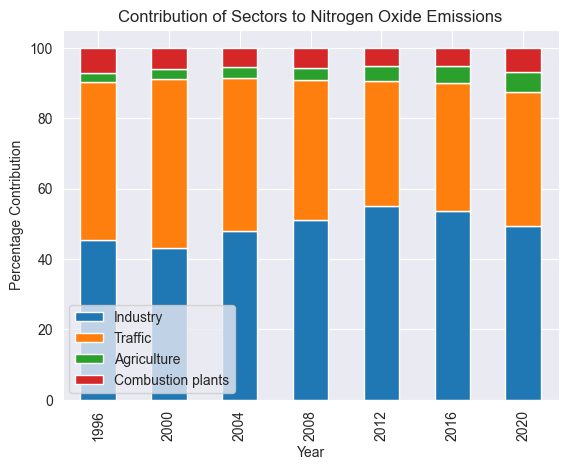

In [308]:

for col in cols:
    df_no2['total_emissions'] = df_no2['total_emissions'] + df_no2[col].astype(float)

# Calculate percentage contribution of each sector
df_no2['industry_contribution'] = (df_no2['nitrogen_oxide_emission--Industry'].astype(float) / df_no2['total_emissions']) * 100
df_no2['traffic_contribution'] = (df_no2['nitrogen_oxide_emission--Traffic'].astype(float) / df_no2['total_emissions']) * 100
df_no2['agriculture_contribution'] = (df_no2['nitrogen_oxide_emission--Agriculture'].astype(float) / df_no2['total_emissions']) * 100
df_no2['combustion_plants_contribution'] = (df_no2['nitrogen_oxide_emission--Small combustion plants'].astype(float) / df_no2['total_emissions']) * 100
#
# # Identify the highest and lowest contributions for each year
df_no2['highest_contribution_sector'] = df_no2[['industry_contribution', 'traffic_contribution', 'agriculture_contribution', 'combustion_plants_contribution']].idxmax(axis=1)
df_no2['lowest_contribution_sector'] = df_no2[['industry_contribution', 'traffic_contribution', 'agriculture_contribution', 'combustion_plants_contribution']].idxmin(axis=1)
#
# # Visualize the contributions over time
ax = df_no2[['industry_contribution', 'traffic_contribution', 'agriculture_contribution', 'combustion_plants_contribution']].plot(kind='bar', stacked=True)
new_legends = ['Industry', 'Traffic', 'Agriculture', 'Combustion plants']
ax.legend(new_legends)
plt.xlabel('Year')
plt.ylabel('Percentage Contribution')
plt.title('Contribution of Sectors to Nitrogen Oxide Emissions')
plt.show()

In [309]:
print_colored(df_no2[['highest_contribution_sector', 'lowest_contribution_sector']], 'blue')

Type highest_contribution_sector lowest_contribution_sector
1996       industry_contribution   agriculture_contribution
2000        traffic_contribution   agriculture_contribution
2004       industry_contribution   agriculture_contribution
2008       industry_contribution   agriculture_contribution
2012       industry_contribution   agriculture_contribution
2016       industry_contribution   agriculture_contribution
2020       industry_contribution   agriculture_contribution


In most of the years, Industry was the most contributing factor with traffic closely following and Agriculture is the least contributor

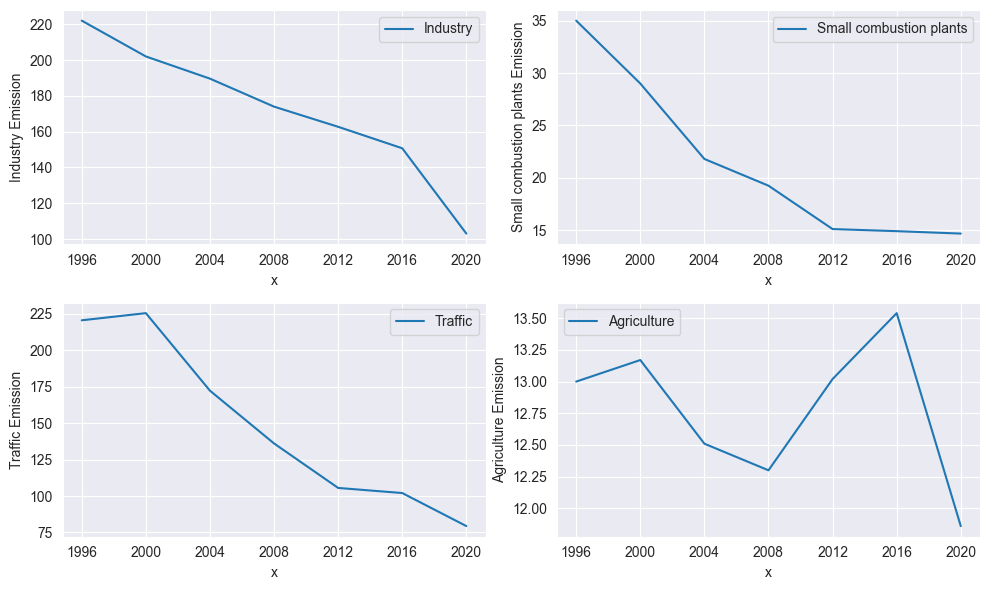

In [310]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

for i, col_name in enumerate(cols.values):
    row = i // 2
    col = i % 2
    label = col_name.split('--')[-1]
    axes[row, col].plot(df_no2[col_name].astype(float), label=col_name.split('--')[-1])
    axes[row, col].set_xlabel('x')
    axes[row, col].set_ylabel(label + ' Emission')
    axes[row, col].legend()

plt.tight_layout()

plt.show()

Industry contributes maximum to total emission but it shows a rapid declining trend over the years.
The industrial emission decreased by about 112% from 1996-2020, which is a good achievement
The emission from Agriculture has meanwhile shows various trends with declining behavior in recent past but following the previous graph.
But its contribution is minimal to total emission

In [311]:
(df_no2['nitrogen_oxide_emission--Industry'].astype(float).iloc[-1] - df_no2['nitrogen_oxide_emission--Industry'].astype(float).iloc[0]*100/df_no2['nitrogen_oxide_emission--Industry'].astype(float).iloc[-1])

-112.37940320232899

## Green house Gases

In [312]:
cols = df_t.columns.str.startswith('greenhouse_gas')
cols = df_t.columns[cols]
df_green = df_t[cols].dropna()

In [313]:
df_green.describe()

Type,greenhouse_gas--Energy industry,greenhouse_gas--Industry,greenhouse_gas--Transport,greenhouse_gas--Households / small-scale consumption,greenhouse_gas--Fl. emissions from fuels,greenhouse_gas--Product applications/other,greenhouse_gas--Agriculture,greenhouse_gas--Waste
count,20,20,20,20,20,20,20,20
unique,20,18,20,19,17,9,9,13
top,159.4,54.7,36.2,28.6,1.9,3.6,7.2,0.5
freq,1,2,1,2,2,6,5,4


## Analyse Green House Gas  Emission Across different Sectors
Analyzing the emissions across different sectors can provide insights into the major contributors to overall greenhouse gas emissions.
By prioritizing sectors for mitigation efforts, we can focus on areas with the greatest potential for reducing emissions.

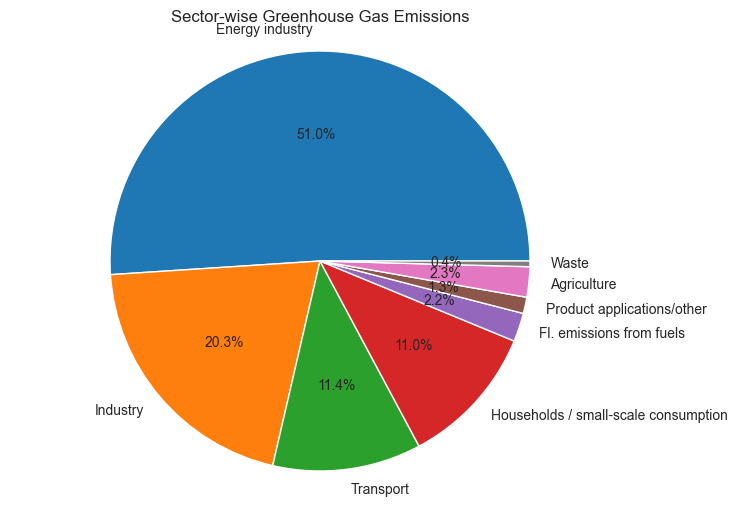

In [314]:
emissions = []
for col in cols:
    emission = df_green[col].astype(float).sum()
    emissions.append(emission)

total_emissions = sum(emissions)

percentage_contributions = [(emission / total_emissions) * 100 for emission in emissions]

formatted_cols = [element.split("--")[-1] for element in cols]


# Create a pie chart to visualize sector-wise emissions
plt.figure(figsize=(8, 6))
plt.pie(percentage_contributions, labels=formatted_cols, autopct='%1.1f%%')
plt.title('Sector-wise Greenhouse Gas Emissions')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

So Energy Industry Contributed more that half of the Greenhouse gases during the period.
It is followed by Industry - more than 1/5th. With Transport and Households having very similar percentage_contribution.
So mitigation efforts has to start from these industries

## Analyse the trend of each sector to see how the sectors did over the years
We try to identify if emissions are increasing, decreasing, or remaining stable in each sector.
This analysis will help assess the effectiveness of current policies and initiatives.


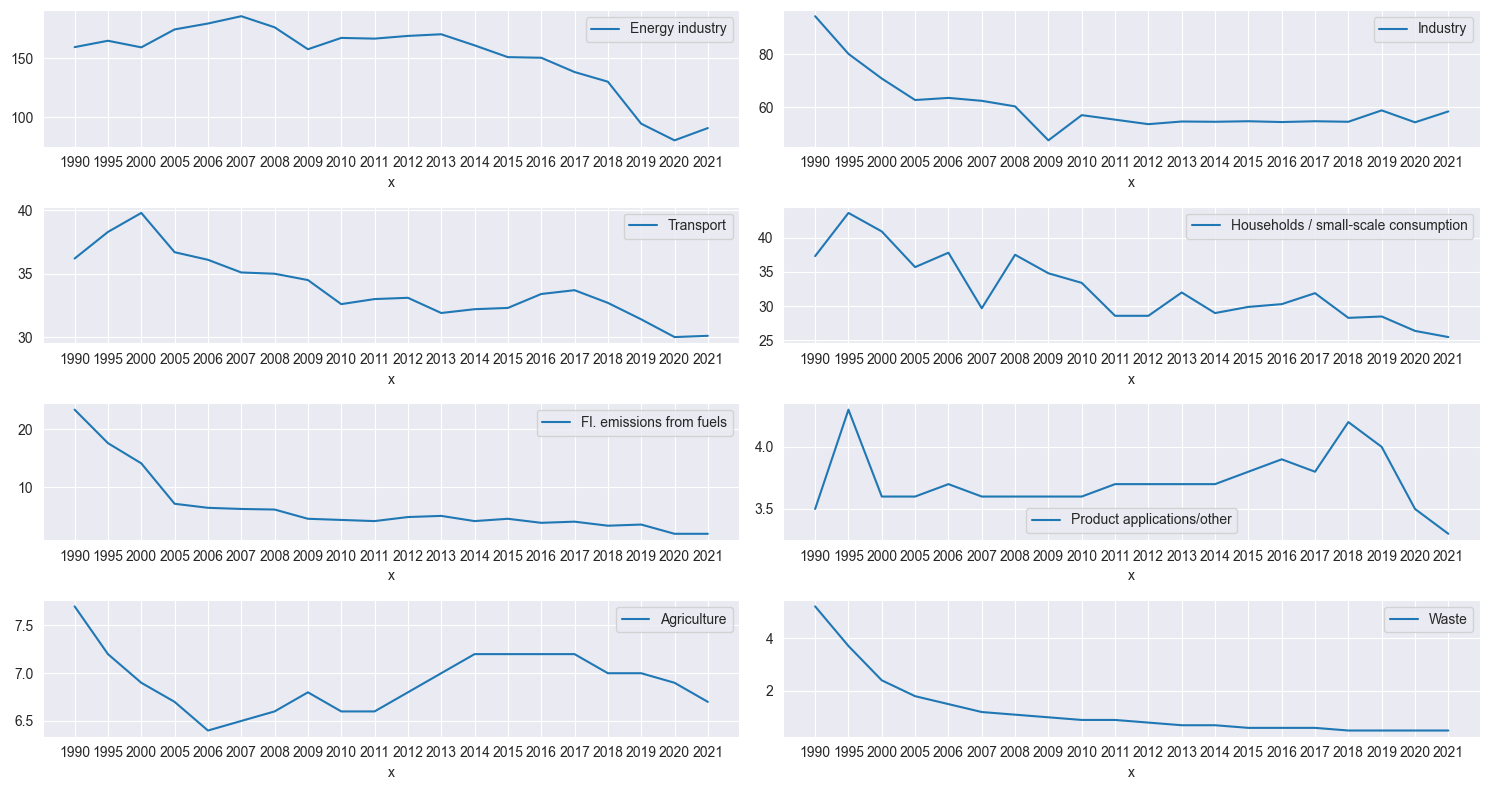

In [315]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 8))

for i, col_name in enumerate(cols.values):
    row = i // 2
    col = i % 2
    label = col_name.split('--')[-1]
    axes[row, col].plot(df_green[col_name].astype(float), label=col_name.split('--')[-1])
    axes[row, col].set_xlabel('x')
    # axes[row, col].set_ylabel(label)
    axes[row, col].legend()

plt.tight_layout()

plt.show()

## The Energy Industry has remained nore or less stationary till 2014 and has shown rapid decrease in the recent past
It could be because of the significant advancements in renewable energy, policy commitments,
and public awareness that was witnessed in the 2010's and adoption of Paris Agreement in 2015.

Every other Sector also shows an overall decreases in the last years but the intermediate years show no single prominent trend accross sectors.

# Analysing Indicators with Positive trend

In [316]:
for var in (trend_slope[:5]):
    print(f"Trend slope for {var['name']}:")
    print_colored(f"{var['slope']}", 'red')

Trend slope for household_waste--Organic Waste:
2.850607287449394
Trend slope for Settlement area--Settlement area:
1.515789473684211
Trend slope for Recycling rate--Recyclingrate:
0.4975708502024294
Trend slope for household_waste--Total Household Waste:
0.3560728744939272
Trend slope for Nature Conservation--Naturschutzflächen:
0.20471457489878556


# House-hold Waste

In [317]:
cols = df_t.columns.str.startswith('household_waste')
cols = df_t.columns[cols]
df_waste = df_t[cols].dropna()

In [318]:
df_waste.columns

Index(['household_waste--Total Household Waste',
       'household_waste--House Hold Waste', 'household_waste--Organic Waste'],
      dtype='object', name='Type')

The source of waste is identified as two sources here
1. Organic Waste
2. Other House Hold waste
Plotting it together to compare their trend



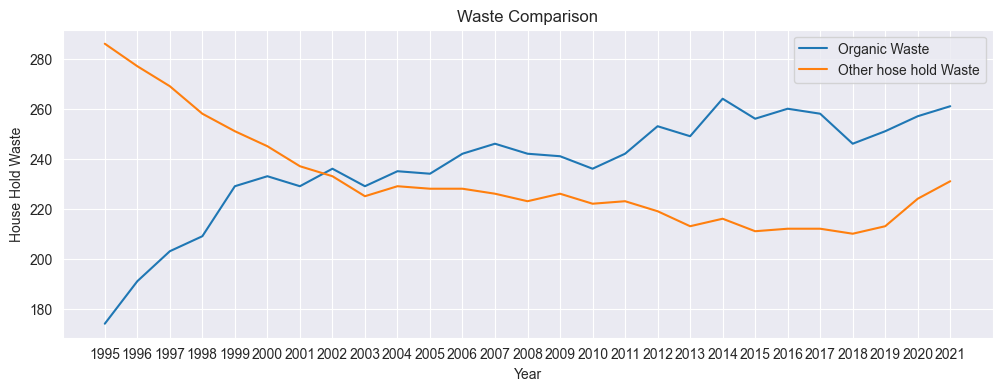

In [319]:
plt.figure(figsize=(12, 4))
organic = df_waste['household_waste--Organic Waste'].astype(float)
other = df_waste['household_waste--House Hold Waste'].astype(float)

plt.plot(organic, label='Organic Waste')
plt.plot(other, label='Other hose hold Waste')
plt.xlabel('Year')
plt.ylabel('House Hold Waste')
plt.title('Waste Comparison')

plt.legend()
plt.show()

There is a welcoming shift of waste generation around 2002, where organic waste surpassed Other House hold waste generation.
This potentialLY indicate a positive change because of Environmental impact.
Organic waste, such as food scraps and yard waste, can be composted or converted into biogas through anaerobic digestion.
Properly managed organic waste can reduce methane emissions from landfills and contribute to soil health and fertility when used as compost.
Non-organic waste, on the other hand, may include materials that are difficult to recycle or degrade slowly in the environment, leading to long-term pollution.

## Recycling Rate

### Considering Recycling potential in the context of differet House Hold waste type
Non-organic waste often includes materials that can be recycled, such as plastics, metals, and paper.
Recycling non-organic waste reduces the consumption of raw materials, energy usage, and greenhouse gas emissions associated with the production of new materials.
While organic waste can be recycled through composting or anaerobic digestion, it may have limited recycling potential in terms of material recovery.
Below we analyse the Recycling Rate over the years.

In [320]:
cols = df_t.columns.str.startswith('Recycling rate')
cols = df_t.columns[cols]
df_recycle = df_t[cols].dropna()

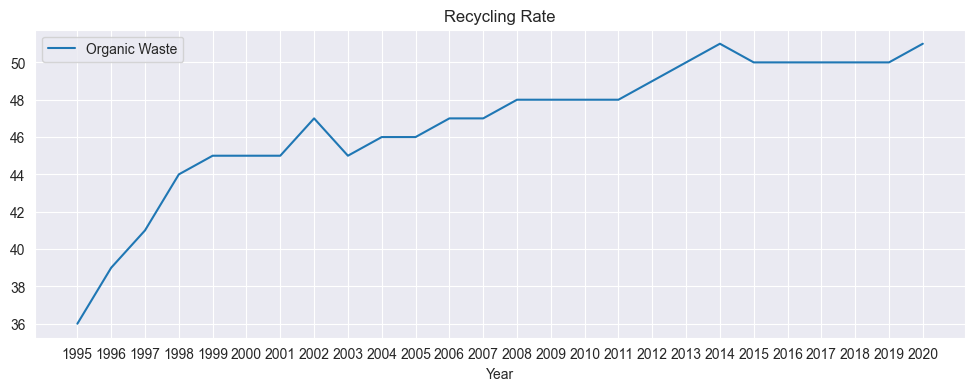

In [321]:
# Plotting the bar plot

years = df_recycle.index.values
values = df_recycle[cols[0]].astype(float)

plt.figure(figsize=(12, 4))

plt.plot(values, label='Organic Waste')
plt.xlabel('Year')
plt.title('Recycling Rate')

plt.legend()
plt.show()

Recycling rate has shown significant increse over the year, which is a higly positive news.
This along with the decrease in non-organic waste point towards the decrease in the non-organic waste footprint in the region.

## Settlement area.

Settlement area refers to an area where human habitation and development occur.
It typically includes urban and rural areas where people live, work, and engage in various activities.

The increase in settlement area can be seen as both  positive and negative environmental indicators in different context
Its impact depends on various factors such as the rate and extent of expansion, land use practices, infrastructure development, and environmental management strategies.

Positives
1. Conservation and restoration efforts: With increased human presence in settlement areas, there can be a greater focus on conservation and restoration initiatives.
2. Environmental awareness and education: Increased settlement areas can create a platform for environmental awareness and education programs.
With a larger population, there is an opportunity to raise awareness about environmental issues, sustainable practices, and the importance of biodiversity conservation.
This can lead to a more environmentally conscious population and increased support for environmental protection efforts.

Negatives
1. Habitat loss and biodiversity: The expansion of settlement areas often involves clearing natural habitats, leading to habitat loss and fragmentation.
2. Increased resource consumption and pollution: Expanding settlement areas generally result in increased resource consumption, energy use, and waste generation.
3. Land degradation: Converting natural or agricultural land into built-up areas can result in soil compaction, erosion, and loss of fertility.


### Quantitative Trend of settlement Area is + 1.515789473684211, which is the highest in an adverse Environmental Indicator



In [322]:
cols = df_t.columns.str.startswith('Settlement area')
cols = df_t.columns[cols]
df_settlement = df_t[cols].dropna()

### Identify the Environmental Indicators that Correlates mostly with Settlement area

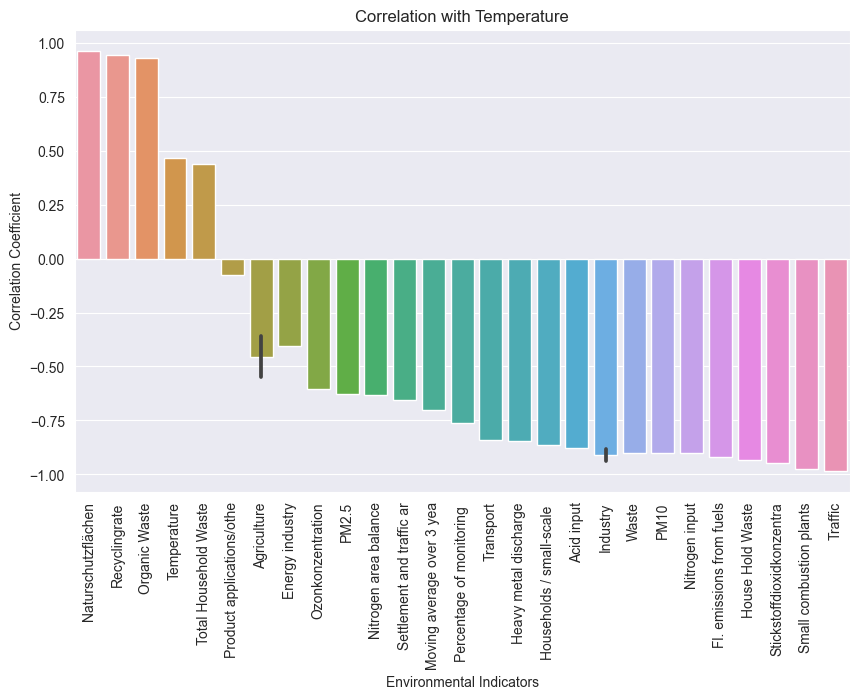

In [323]:
correlation_with_settlement = correlation_matrix[cols[0]]
sorted_correlations = correlation_with_settlement.sort_values(ascending=False)
plt.figure(figsize=(10, 6))  # Set the figure size
formatted_cols = [element.split("--")[-1][0:25] for element in sorted_correlations.index.values]
sns.barplot(x=formatted_cols[1:], y=sorted_correlations.values[1:])
plt.title('Correlation with Temperature')  # Set the title of the plot
plt.xlabel('Environmental Indicators')  # Set the x-axis label
plt.ylabel('Correlation Coefficient')  # Set the y-axis label
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


In [324]:
df_settlement_positive_corr = sorted_correlations[1:5]
print(df_settlement_positive_corr)


Type
Nature Conservation--Naturschutzflächen    0.964718
Recycling rate--Recyclingrate              0.943369
household_waste--Organic Waste             0.931595
temperature--Temperature                   0.468844
Name: Settlement area--Settlement area, dtype: float64


## We see that seetlement area is strongly correlated with
1. Nature Conservation - Meaning With increased human presence and awareness in settlement areas, there can be a greater focus on conservation and restoration initiatives.
2. Recycling Rate - Meaning as settlement areas grow, there can be an opportunity to implement more advanced waste management systems.
3. Organic Waste Generation - Meaning better recycling programs and composting initiatives.

In conclusion with proper planning and sustainable practices, settlement areas can be developed in a way that minimizes their negative environmental impacts and promotes environmental sustainability.

# Predict Average Temperature from time series temperature data

We have analysed different environmental features and their correlation to temperature.
Now we are trying to predict the average temperature for Future Years.

For this a simple ARIMA model is used.
ARIMA stands for AutoRegressive Integrated Moving Average.
It is a widely used model for analyzing and forecasting time series data.
The ARIMA model is particularly captures different components of time series data, such as trends, seasonality, and random fluctuations.


In [325]:
temperature_real_df =  pd.read_sql_table('temperature', 'sqlite:///../data/dataset.sqlite',coerce_float = True)
temperature_df = temperature_real_df.reset_index()
temperature_df['Year'] = pd.to_datetime(temperature_df['Year'], format='%Y')
temperature_df.set_index('Year', inplace = True)

warnings.filterwarnings("ignore")
x = temperature_df['Temperature']

model = ARIMA(x, order=(4, 2, 1))
model_fit = model.fit()

# Predict the future average temperatures
future_years = pd.date_range(start='2022', end='2030', freq='A')
predicted_temperatures = model_fit.predict(start=len(x), end=len(x) + len(future_years)-1)

predicted_df = pd.DataFrame({'Year': future_years.year, 'Temperature': predicted_temperatures})
predicted_df.set_index('Year', inplace = True)
print(predicted_df)
warnings.filterwarnings("default")
temperature_df.reset_index(inplace =True)
predicted_df.reset_index(inplace =True)

      Temperature
Year             
2022    10.714588
2023    10.977383
2024    10.859162
2025    10.703580
2026    10.903150
2027    10.840137
2028    10.941257
2029    10.910489


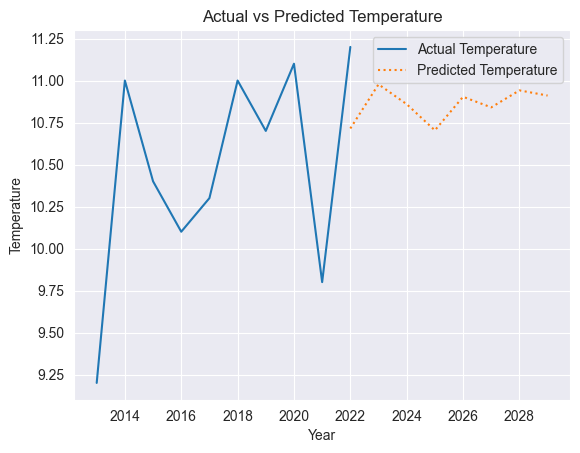

In [326]:
fig, ax = plt.subplots()

# Plot the actual temperature data

years = temperature_df['Year'].dt.year[-10:]
ax.plot(years, temperature_df['Temperature'][-10:], label='Actual Temperature')

# Plot the predicted temperature data as a dotted line
ax.plot(predicted_df['Year'], predicted_df['Temperature'], linestyle='dotted', label='Predicted Temperature')

# Set the x-axis label
ax.set_xlabel('Year')

# Set the y-axis label
ax.set_ylabel('Temperature')

# Set the title of the plot
ax.set_title('Actual vs Predicted Temperature')

# Display the legend
ax.legend()

# Show the plot
plt.show()


### We used a very simple ARIMA model to predict the Future Average Temperature and it is showing a varying but overall upward trend.
The model outlined here is very basic and hence no model evaluation is performed to keep simplicity

# Conclusion
The analysis of different environmental indicators and average yearly temperature has provided valuable insights into the state of our environment and its relationship with climate change.
Through this project, we examined various environmental factors such and explored their correlation with average yearly temperature.
## Important Findings
### Temperature
1. The average temperature has a definite increasing trend over the years. Performing Linear Regression for trend analysis gives us as 1.25 % average increase per year
2. In years 1922, 1962, 1996 we set high negative deviations from the previous years values.
3. In years 1957 1997 2011 2014 we see high positive deviations from the previous year values
4. We didn't observe any outliers in our data
5. Forcasting Average temperature over the next 8 years using a baisc ARIMA model gave us an increasing trend with variations.

### Environment Indicators
1. We couldn't observe significant correlation between the indicators we considered and temperature data. The correlation seen was surprising and is assumed just due to the underlying increasing trend. The exceptions are Settlement Area and Household waste. Both which show increase and could lead to adverse environmental effects.
2. Many Indicators like Nitrogen Oxide Emission, Inorganic Waste Generation, Greenhouse gas emission has shown a decreasing trend over the years, which affect environment positively
3. Indicators like Organic Waste, Recycling Area and Nature Conservation shows an increasing trend, which is also a direction in positive impact on environment
4. Settlement area and total Household waste has an increasing trend with settlement area with a slope value of 1.515. This could be a worrying trend. But we see that Settlement area is very strongly correlated with Nature Conservation, Recycling Rate and Organic Waste. This could indicate that with increasing settlement area greater focus on conservation, advanced waste management and beter recycling initiatives are developed.

In conclusion almost all of the Environmental Indicators show a positive outlook when it comes to environmental conservation efforts.
The increase in average temperature could be possibly attributed to the Natural Climate Variability due to Global Warming and some indicators like Deforestation, Industrial Activities, Urbanisation etc that we haven't considered here because of unavailability of data.